In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# LFW-Datensatz laden
(dataset_train, dataset_test), info = tfds.load('lfw', split=['train[:80%]', 'train[80%:]'], with_info=True)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/13233 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/lfw/incomplete.BZL8K7_0.1.0/lfw-train.tfrecord*...:   0%|          | 0/132…

Dataset lfw downloaded and prepared to /root/tensorflow_datasets/lfw/0.1.0. Subsequent calls will reuse this data.


In [3]:
def add_mask(image):
    # Bild maskieren
    masked_image = image.numpy()
    x1, y1 = 32, 32  # obere linke Ecke des Rechtecks
    x2, y2 = 40, 40  # untere rechte Ecke des Rechtecks
    masked_image[y1:y2, x1:x2, :] = 0
    return masked_image


In [4]:
IMG_WIDTH = 64
IMG_HEIGHT = 64

def preprocess(data):
    image = data['image']
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    image = image / 255.0  # Normalisierung

    # Maskiertes Bild erstellen
    masked_image = tf.py_function(add_mask, [image], tf.float32)
    masked_image.set_shape([IMG_HEIGHT, IMG_WIDTH, 3])

    return masked_image, image  # Eingabe ist maskiertes Bild, Ziel ist Originalbild



In [5]:
BATCH_SIZE = 128

train_dataset = dataset_train.map(preprocess).shuffle(1000).batch(BATCH_SIZE)
test_dataset = dataset_test.map(preprocess).batch(BATCH_SIZE)


In [6]:
def build_encoder():
    encoder_input = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))

    # Erste Convolutional-Schicht
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(encoder_input)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)

    # Zweite Convolutional-Schicht
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)

    # Dritte Convolutional-Schicht
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)

    # Vierte Convolutional-Schicht
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    encoder_output = layers.MaxPooling2D((2, 2), padding='same')(x)

    return models.Model(encoder_input, encoder_output, name='encoder')


In [7]:
def build_decoder():
    decoder_input = layers.Input(shape=(4, 4, 512))

    # Erste UpSampling-Schicht
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(decoder_input)
    x = layers.BatchNormalization()(x)
    x = layers.UpSampling2D((2, 2))(x)

    # Zweite UpSampling-Schicht
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.UpSampling2D((2, 2))(x)

    # Dritte UpSampling-Schicht
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.UpSampling2D((2, 2))(x)

    # Vierte UpSampling-Schicht
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.UpSampling2D((2, 2))(x)

    # Letzte Convolutional-Schicht
    decoder_output = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    return models.Model(decoder_input, decoder_output, name='decoder')

In [8]:
encoder = build_encoder()
decoder = build_decoder()

autoencoder_input = encoder.input
encoded_output = encoder(autoencoder_input)
decoded_output = decoder(encoded_output)

autoencoder = models.Model(autoencoder_input, decoded_output, name='autoencoder')


In [9]:
autoencoder.compile(optimizer='adam', loss='mean_squared_error')


In [10]:
EPOCHS = 60  # Sie können die Anzahl der Epochen erhöhen, um bessere Ergebnisse zu erzielen

history = autoencoder.fit(train_dataset,
                          epochs=EPOCHS,
                          validation_data=test_dataset)


Epoch 1/60
83/83 ━━━━━━━━━━━━━━━━━━━━ 53s 393ms/step - loss: 0.0527 - val_loss: 0.0681
Epoch 2/60
83/83 ━━━━━━━━━━━━━━━━━━━━ 15s 177ms/step - loss: 0.0190 - val_loss: 0.0598
Epoch 3/60
83/83 ━━━━━━━━━━━━━━━━━━━━ 15s 178ms/step - loss: 0.0158 - val_loss: 0.0399
Epoch 4/60
83/83 ━━━━━━━━━━━━━━━━━━━━ 15s 179ms/step - loss: 0.0133 - val_loss: 0.0290
Epoch 5/60
83/83 ━━━━━━━━━━━━━━━━━━━━ 15s 175ms/step - loss: 0.0116 - val_loss: 0.0199
Epoch 6/60
83/83 ━━━━━━━━━━━━━━━━━━━━ 15s 176ms/step - loss: 0.0111 - val_loss: 0.0141
Epoch 7/60
83/83 ━━━━━━━━━━━━━━━━━━━━ 15s 174ms/step - loss: 0.0102 - val_loss: 0.0108
Epoch 8/60
83/83 ━━━━━━━━━━━━━━━━━━━━ 15s 177ms/step - loss: 0.0096 - val_loss: 0.0101
Epoch 9/60
83/83 ━━━━━━━━━━━━━━━━━━━━ 15s 175ms/step - loss: 0.0094 - val_loss: 0.0101
Epoch 10/60
83/83 ━━━━━━━━━━━━━━━━━━━━ 15s 175ms/step - loss: 0.0087 - val_loss: 0.0089
Epoch 11/60
83/83 ━━━━━━━━━━━━━━━━━━━━ 15s 175ms/step - loss: 0.0083 - val_loss: 0.0091
Epoch 12/60
83/83 ━━━━━━━━━━━━━━━━━━━━ 15

In [15]:
# Testdaten vorbereiten
num_examples = 20
test_dataset_iter = iter(test_dataset)
masked_images, original_images = next(test_dataset_iter)

# Rekonstruktion mit dem Autoencoder
reconstructed_images = autoencoder.predict(masked_images)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


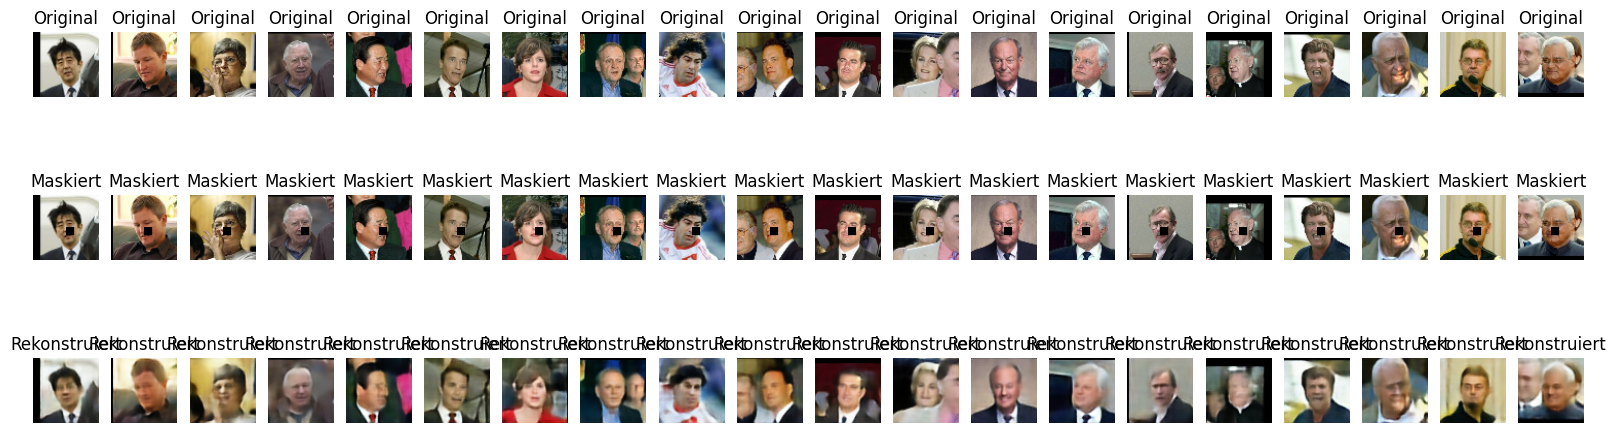

In [16]:
n = num_examples
plt.figure(figsize=(20, 6))
for i in range(n):
    # Original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(original_images[i])
    plt.title("Original")
    plt.axis('off')

    # Maskiert
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(masked_images[i])
    plt.title("Maskiert")
    plt.axis('off')

    # Rekonstruiert
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(reconstructed_images[i])
    plt.title("Rekonstruiert")
    plt.axis('off')
plt.show()
